In [1]:
import operator
import random
import requests
import time
import csv
import os
import pandas as pd
import seaborn as sns
import numpy as np
import networkx as nx
import scipy
from scipy import stats
from ast import literal_eval
from matplotlib import pyplot as plt
from statsmodels.stats import diagnostic
from datetime import datetime
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split

# Data standard scaler
from sklearn.preprocessing import StandardScaler

# Random train-test split
from sklearn.model_selection import train_test_split

# Metrics and model selection
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, auc, roc_curve, precision_recall_curve
from sklearn.model_selection import cross_val_predict

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from scipy.stats import ttest_ind

from networkx.algorithms import bipartite

#To visualize on of the RandomForest decision trees
#from sklearn import tree

#colors used when comparing genders
PURPLE = 'purple'
ORANGE = '#ffb82c'

#colors used when generic comparisons
BLUE = '#0173b2'
RED = '#d55e00'

#print(sns.color_palette("colorblind").as_hex())
#sns.color_palette("colorblind")

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# 1. Load the data
<a class="anchor" id="load"></a>

In [3]:
DATA_PATH = './data'
MOVIE_PATH = os.path.join(DATA_PATH, 'american_movies_filtered.tsv')
CHAR_PATH = os.path.join(DATA_PATH, 'characters_filtered.tsv')
THE_NUMBERS_PATH = os.path.join(DATA_PATH, 'the_numbers_lifetime_cumulative.tsv')
THE_NUMBERS_SCORE_PATH = os.path.join(DATA_PATH, 'the_numbers_yearly_score.tsv')

### 1.1 Characters data
<a class="anchor" id="load_characters"></a>

In [4]:
df_chars=pd.read_csv(CHAR_PATH, sep="\t")
df_chars['m_release_date']=pd.to_datetime(df_chars['m_release_date'], errors = 'coerce')
df_chars.head(2)

,wikipedia_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_name,m_genre_PCA
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,Ghosts of Mars,"Thriller, Crime Thriller, Action, Mystery"
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,NaN,Natasha Henstridge,27.0,Ghosts of Mars,"Thriller, Crime Thriller, Action, Mystery"


### 1.2 The data score

In [5]:
df_numbers=pd.read_csv(THE_NUMBERS_SCORE_PATH, sep='\t').set_index('actor_name')
df_numbers.reset_index(inplace=True)
df_numbers.head(2)

,actor_name,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2005,2006,2007,2008,2009,2010,2011,2012,min_year,min_year_score
0,Jane Fonda,2475.0,3910.5,2161.5,1509.75,1163.25,947.100000,2689.071429,1636.232143,1239.125000,...,3026.612308,1649.474359,1183.301948,945.483026,799.422414,699.538710,626.261864,569.781250,1980,2475.0
1,Clint Eastwood,5394.0,2697.0,4636.0,5963.50,9801.80,8879.333333,8991.838095,5988.366667,7511.228571,...,5771.129002,4778.685758,4185.983006,8665.604883,5901.331475,4831.223973,4212.135890,4683.724922,1980,5394.0


# 2.1 Dataset preparation

In [6]:
df_chars_merged = df_chars.merge(df_numbers, on='actor_name', how='left').copy()
numbers_columns = df_numbers.columns[1:]
df_chars_merged[numbers_columns] = df_chars_merged[numbers_columns].fillna(0)
df_chars_merged['min_year'] = df_chars_merged['min_year'].astype('int')
df_chars_merged.head()

,wikipedia_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_name,...,2005,2006,2007,2008,2009,2010,2011,2012,min_year,min_year_score
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,Ghosts of Mars,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.0
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,NaN,Natasha Henstridge,27.0,Ghosts of Mars,...,76.000000,65.142857,57.000000,50.666667,45.600000,41.454545,38.000000,35.076923,2000,456.0
2,975900,2001-08-24,Desolation Williams,1969-06-15,M,1.727,African Americans,Ice Cube,32.0,Ghosts of Mars,...,3255.369913,1990.897222,2641.254319,2432.196392,1729.285333,1391.918606,1179.534513,1029.515124,1991,78.0
3,975900,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,Ghosts of Mars,...,715.333333,426.228571,311.050000,930.650794,546.942857,2009.549784,1152.650000,2576.304895,2000,38.0
4,975900,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea Duvall,23.0,Ghosts of Mars,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.0


In [7]:
nb_actors = df_chars_merged['actor_name'].nunique()
print("There are {} actors in this dataset.".format(nb_actors))

There are 34387 actors in this dataset.


In [8]:
df_chars_merged['is_revealed'] = df_chars_merged.apply(lambda row: row['min_year'] == row['m_release_date'].year, axis=1).astype(int)
df_chars_merged['already_revealed'] = df_chars_merged.apply(lambda row: row['min_year'] < row['m_release_date'].year and row['min_year']!=0, axis=1).astype(int)
df_chars_merged.head()

,wikipedia_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_name,...,2007,2008,2009,2010,2011,2012,min_year,min_year_score,is_revealed,already_revealed
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,Ghosts of Mars,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.0,0,0
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,NaN,Natasha Henstridge,27.0,Ghosts of Mars,...,57.000000,50.666667,45.600000,41.454545,38.000000,35.076923,2000,456.0,0,1
2,975900,2001-08-24,Desolation Williams,1969-06-15,M,1.727,African Americans,Ice Cube,32.0,Ghosts of Mars,...,2641.254319,2432.196392,1729.285333,1391.918606,1179.534513,1029.515124,1991,78.0,0,1
3,975900,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,Ghosts of Mars,...,311.050000,930.650794,546.942857,2009.549784,1152.650000,2576.304895,2000,38.0,0,1
4,975900,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea Duvall,23.0,Ghosts of Mars,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.0,0,0


# 2.2 Movies that have a revelation

In [95]:
df_movie_revelation = df_chars_merged.groupby(['wikipedia_m_ID', 'm_release_date', 'm_genre_PCA']).agg({'is_revealed': 'sum', 'already_revealed':'sum'}).copy().reset_index()
df_movie_revelation['m_release_year'] = df_movie_revelation['m_release_date'].dt.year
df_movie_revelation.rename({'is_revealed' : 'has_revelation', 'already_revealed' : 'has_famous_actors'}, axis=1, inplace=True)
df_movie_revelation['has_revelation'] = (df_movie_revelation['has_revelation'] > 0).astype(int)
df_movie_revelation.head()

,wikipedia_m_ID,m_release_date,m_genre_PCA,has_revelation,has_famous_actors,m_release_year
0,3217,1992-10-09,"Horror, B-movie, Gay, Gay Interest",1,0,1992
1,3333,1915-01-01,"Sword and sorcery films, Sword and sorcery, De...",0,0,1915
2,3746,1982-06-25,"Thriller, Crime Thriller, Action, Mystery",1,1,1982
3,3837,1974-02-07,"Comedy, Gross-out film, Gross out, Romantic co...",0,0,1974
4,3947,1986-08-01,"Thriller, Crime Thriller, Action, Mystery",0,0,1986


In [96]:
df_movie_revelation['has_revelation'].value_counts()

0    23067
1     1817
Name: has_revelation, dtype: int64

In [97]:
nb_movies = df_movie_revelation['wikipedia_m_ID'].nunique()
nb_movies_revelation = df_movie_revelation['has_revelation'].value_counts()[1]
print("There are {} movies with a revelation which represents {:.2f}% of the movies.".format(nb_movies_revelation, nb_movies_revelation*100/nb_movies))
#df_movie_revelation = df_movie_revelation.loc[(df_movie_revelation['has_revelation'] > 0)]

There are 1817 movies with a revelation which represents 7.30% of the movies.


In [98]:
nb_movies_with_famous_actor = df_movie_revelation.loc[(df_movie_revelation['has_famous_actors']>0) & (df_movie_revelation['has_revelation']>0)].shape[0]
print("Among movies with a revelation, there are {} movies with at least one famous actor which represents {:.2f}% of the movies with revelation.".format(nb_movies_with_famous_actor, nb_movies_with_famous_actor*100/nb_movies_revelation))

Among movies with a revelation, there are 1445 movies with at least one famous actor which represents 79.53% of the movies with revelation.


In [99]:
#For the movie with no famous actor, the revelation must come from another factor than co-acting.
#Therefore, we decided to only focus on movies that had at least one actor, to analyse co-acting impact.
df_movie_revelation = df_movie_revelation.loc[(df_movie_revelation['has_famous_actors'] > 0)]
df_movie_revelation.head()

,wikipedia_m_ID,m_release_date,m_genre_PCA,has_revelation,has_famous_actors,m_release_year
2,3746,1982-06-25,"Thriller, Crime Thriller, Action, Mystery",1,1,1982
6,4231,1992-07-31,"Horror, B-movie, Gay, Gay Interest",0,2,1992
7,4560,1995-05-18,"Biography, Culture & Society, Social issues, D...",0,1,1995
8,4726,1989-06-19,"Thriller, Crime Thriller, Action, Mystery",0,3,1989
10,4728,1992-06-16,"Thriller, Crime Thriller, Action, Mystery",0,3,1992


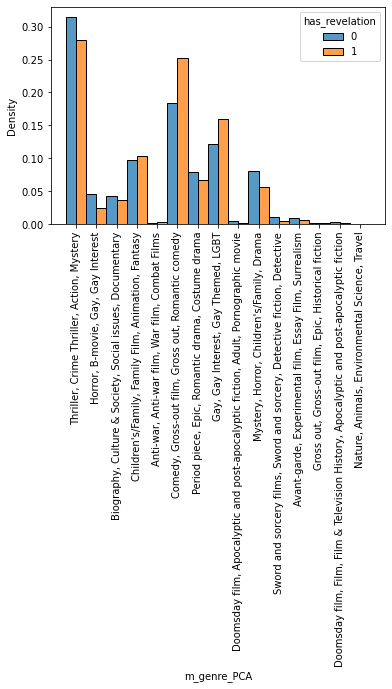

In [112]:
sns.histplot(data=df_movie_revelation, x='m_genre_PCA', hue='has_revelation', multiple="dodge", stat='density', common_norm=False)
plt.xticks(rotation=90);

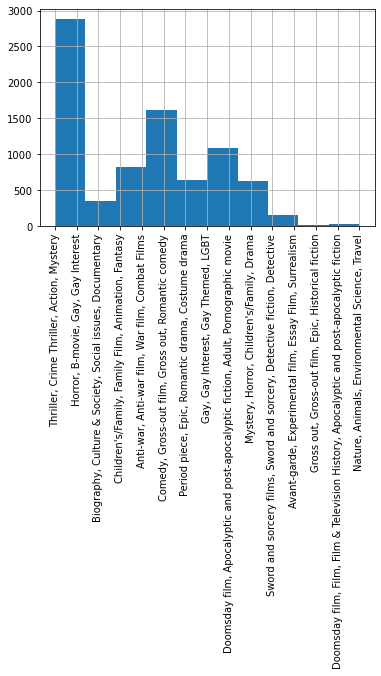

In [106]:
df_movie_revelation['m_genre_PCA'].hist()
plt.xticks(rotation=90);

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

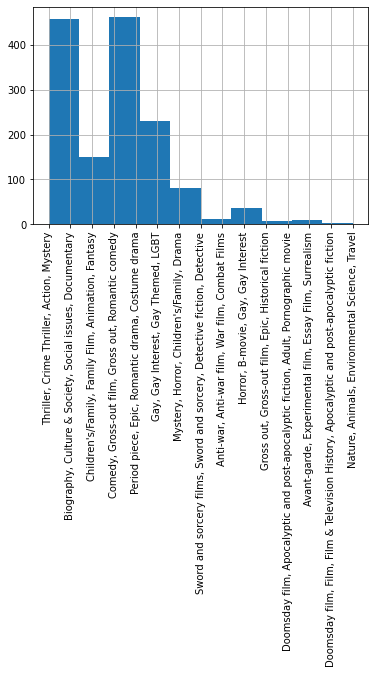

In [107]:
df_movie_revelation[df_movie_revelation['has_revelation']>0]['m_genre_PCA'].hist()
plt.xticks(rotation=90)

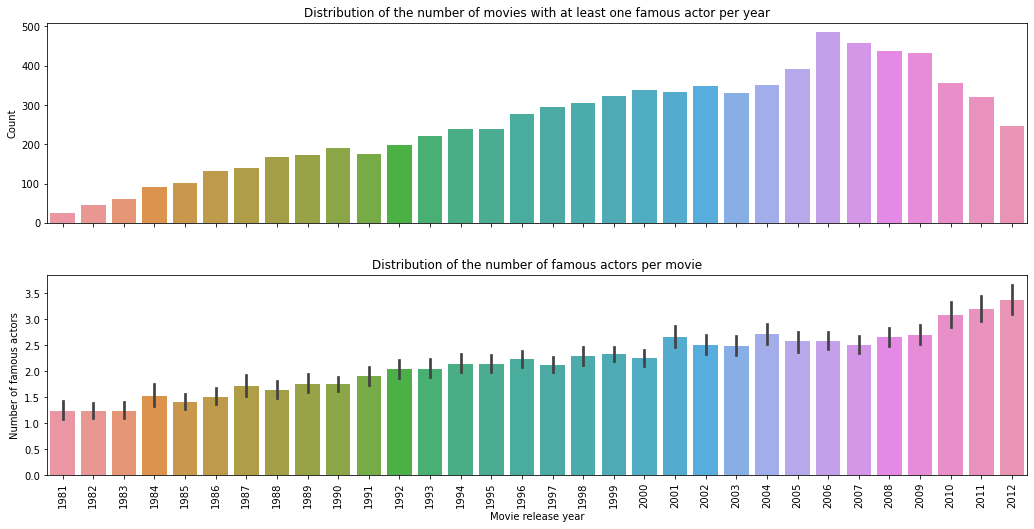

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
data_grouped = df_movie_revelation.groupby('m_release_year')['wikipedia_m_ID'].count().reset_index()
ax = axs[0]
sns.barplot(data=data_grouped,x='m_release_year', y='wikipedia_m_ID', ax=ax)
ax.set_title("Distribution of the number of movies with at least one famous actor per year")
ax.set_xlabel('')
ax.set_ylabel('Count')

ax = axs[1]
sns.barplot(data=df_movie_revelation,x='m_release_year', y='has_famous_actors', ax=ax)
ax.set_title("Distribution of the number of famous actors per movie")
plt.xticks(rotation = 90)
fig.tight_layout(pad=3.0)
ax.set_xlabel('Movie release year')
ax.set_ylabel('Number of famous actors')
plt.show()

As it can be seen, there is an increase in the number of movies per year but also a major increase in the number of famous actors per movie.
The second observation can be due to two facts:
* The global increase in the number of movies
* The scoring system: once you've been releaved, you stay famous. But the earlier we are, the less information we have about actors that were releaved before 1980 but for whom we don't have an accurate score.

For those two reasons, the time period will be split into 6 blocks, so that movies with comparable number of famous actors will be compared.

# 2.2 Revelation per pentade

In [15]:
nb_five_years_lower = range(1982, 2008,5)
nb_five_years_upper = range(1987, 2013, 5)

In [16]:
def define_popularity(min_year, lower_bound, upper_bound):
    if not min_year or min_year >= upper_bound:
        return 'unknown'
    if min_year < lower_bound:
        return 'famous'
    else:
        return 'revelation'

In [89]:
df_chars_revelation = df_movie_revelation.merge(df_chars_merged, on=['wikipedia_m_ID', 'm_release_date'], how='inner').copy()
df_revelations_five_years = dict()
for y_lower, y_upper in zip(nb_five_years_lower, nb_five_years_upper):
    filter_conditions = (
        (df_chars_revelation['m_release_date'].dt.year >= y_lower) & 
        (df_chars_revelation['m_release_date'].dt.year < y_upper)
    )
    columns = ['wikipedia_m_ID', 'm_name', 'm_release_date', 'm_genre_PCA','actor_name', 'is_revealed', 'already_revealed', 'min_year']
    df_filtered = df_chars_revelation.loc[filter_conditions, columns].copy()
    df_filtered['popularity'] = df_filtered['min_year'].apply(lambda x: define_popularity(x, y_lower, y_upper))
    df_revelations_five_years.update({range(y_lower, y_upper): df_filtered.copy()})

In [93]:
df_revelations_five_years[range(1982,1987)]['m_genre_PCA'].value_counts()

Comedy, Gross-out film, Gross out, Romantic comedy                                    1042
Thriller, Crime Thriller, Action, Mystery                                             1033
Gay, Gay Interest, Gay Themed, LGBT                                                    423
Mystery, Horror, Children's/Family, Drama                                              409
Children's/Family, Family Film, Animation, Fantasy                                     389
Period piece, Epic, Romantic drama, Costume drama                                      352
Horror, B-movie, Gay, Gay Interest                                                     230
Biography, Culture & Society, Social issues, Documentary                               202
Sword and sorcery films, Sword and sorcery, Detective fiction, Detective                80
Avant-garde, Experimental film, Essay Film, Surrealism                                  13
Anti-war, Anti-war film, War film, Combat Films                                         12

In [94]:
df_revelations_five_years[range(1982,1987)]

,wikipedia_m_ID,m_name,m_release_date,m_genre_PCA,actor_name,is_revealed,already_revealed,min_year,popularity
0,3746,Blade Runner,1982-06-25,"Thriller, Crime Thriller, Action, Mystery",William Sanderson,0,0,0,unknown
1,3746,Blade Runner,1982-06-25,"Thriller, Crime Thriller, Action, Mystery",Harrison Ford,0,1,1980,famous
2,3746,Blade Runner,1982-06-25,"Thriller, Crime Thriller, Action, Mystery",Rutger Hauer,0,0,1985,revelation
3,3746,Blade Runner,1982-06-25,"Thriller, Crime Thriller, Action, Mystery",Sean Young,1,0,1982,revelation
4,3746,Blade Runner,1982-06-25,"Thriller, Crime Thriller, Action, Mystery",Daryl Hannah,0,0,1984,revelation
...,...,...,...,...,...,...,...,...,...
84331,34152774,The Bad Seed,1985-02-07,"Thriller, Crime Thriller, Action, Mystery",Michael Beck,0,0,0,unknown
84332,34152774,The Bad Seed,1985-02-07,"Thriller, Crime Thriller, Action, Mystery",Blair Brown,0,1,1981,famous
84333,34152774,The Bad Seed,1985-02-07,"Thriller, Crime Thriller, Action, Mystery",Richard Kiley,0,0,0,unknown
84334,34152774,The Bad Seed,1985-02-07,"Thriller, Crime Thriller, Action, Mystery",Lynn Redgrave,0,0,0,unknown


In [85]:
df_chars_revelation['m_genre_PCA'].value_counts()

Thriller, Crime Thriller, Action, Mystery                                                   24848
Comedy, Gross-out film, Gross out, Romantic comedy                                          18655
Gay, Gay Interest, Gay Themed, LGBT                                                         11412
Children's/Family, Family Film, Animation, Fantasy                                           9381
Period piece, Epic, Romantic drama, Costume drama                                            6708
Mystery, Horror, Children's/Family, Drama                                                    5419
Biography, Culture & Society, Social issues, Documentary                                     3491
Horror, B-movie, Gay, Gay Interest                                                           3002
Avant-garde, Experimental film, Essay Film, Surrealism                                        667
Sword and sorcery films, Sword and sorcery, Detective fiction, Detective                      612
Doomsday film, Apoca

In [18]:
def get_attributes(df_, graph_, previous_score):
    df_revelation = df_.merge(graph_.drop_duplicates('actor_name_x', keep='first'), left_on='actor_name', right_on='actor_name_x', how='inner')[['actor_name', 'min_year', 'popularity']]
    revelation = df_revelation.drop_duplicates(keep='first').set_index('actor_name').to_dict('index')
    
    df_famous = df_.merge(graph_.drop_duplicates('actor_name_y', keep='first'), left_on='actor_name', right_on='actor_name_y', how='inner')[['actor_name', 'min_year', 'popularity' , '{}'.format(previous_score)]]
    famous = df_famous.drop_duplicates(keep='first').set_index('actor_name').to_dict('index')
    
    attrs_ = dict()
    attrs_.update(revelation)
    attrs_.update(famous)
    
    return revelation, famous, attrs_

In [19]:
def create_bipartite_graph(revelation, famous, attrs_, graph_):
    B = nx.Graph()
    B.add_nodes_from(revelation, bipartite=0)
    B.add_nodes_from(famous, bipartite=1)
    B.add_weighted_edges_from([(row['actor_name_x'], row['actor_name_y'], 1) for idx, row in graph_.iterrows()], weight='weight')

    colors = []
    for node in B:
        val = attrs_[node]['popularity']
        if val =='revelation':
            colors.append("green")
        elif val =='famous':
            colors.append("red")
        else:
            colors.append("gray")
    
    pos = {node:[0, i] for i,node in enumerate(revelation.keys())}
    pos.update({node:[1, i] for i,node in enumerate(famous.keys())})
    
    bipartite_graph = {'graph': B, 'pos': pos, 'node_color':colors}
    
    return bipartite_graph

In [75]:
def compute_career_boosters_infos(df_, graph_, range_y):
    career_booster_infos = dict()
    for i, x in enumerate(df_[:5], start=1):
        key = x['actor_name']
        score = x['score_in_{}'.format(range_y.start-1)]
        min_year = x['revealed_in']
        ranking = i
        casting = graph_[graph_['actor_name_y'] == key]
        nb_actors_boosted_at_revelation = casting[casting['is_revealed_x'] == 1].shape[0]
        nb_actors_boosted_before_revelation = casting[casting['is_revealed_x'] == 0].shape[0]
        nb_actors_boosted = casting.shape[0]
        tmp_booster = {'booster_in': range_y,
                       'ranking': i,
                       'actor_score_before_period': score,
                       'nb_actors_boosted': nb_actors_boosted,
                       'nb_actors_boosted_at_revelation': nb_actors_boosted_at_revelation,
                       'nb_actors_boosted_before_revelation': nb_actors_boosted_before_revelation
        }
        career_booster_infos.update({key: tmp_booster})
    return career_booster_infos

In [62]:
def extract_partition_nodes(G: nx.Graph, partition: str):
    nodeset = [x for x in G.nodes if attrs[x]['popularity'] == partition]
    if partition != "revelation" and partition!="famous":
        raise Exception(f"No nodes exist in the partition {partition}!")
    return nodeset

In [73]:
def retrieve_career_boosters(graph_, previous_score, attrs_):
    revelations_ = extract_partition_nodes(graph_, "revelation")
    famous_ = extract_partition_nodes(graph_, "famous")
    
    sources = revelations_
    targets = revelations_
    measures = dict()
    measures=['betweenness_centrality_subset', 'degree_centrality']
    
    bc_subset = nx.betweenness_centrality_subset(graph_, sources=sources, targets=targets)
    cc_subset = nx.degree_centrality(graph_)
    
    sorted_bc = sorted(bc_subset.items(), key=lambda kv: kv[1], reverse=True)
    sorted_cc = sorted(cc_subset.items(), key=lambda kv: kv[1], reverse=True)
    career_boosters_bc = []
    career_boosters_cc = []
    for (x, m) in sorted_bc:
        if attrs_[x]['popularity']=='famous':
            score = attrs_[x]['{}'.format(previous_score)]
            min_year = attrs_[x]['min_year']
            bc_measure = m
            cc_measure = cc_subset[x]
            famous_actor = {'actor_name':x, 'score_in_{}'.format(previous_score):score, 'revealed_in':min_year, 'betweenness_centrality_subset':bc_measure, 'degree_centrality':cc_measure}
            career_boosters_bc.append(famous_actor)
    for (x, m) in sorted_cc:
        if attrs_[x]['popularity']=='famous':
            score = attrs_[x]['{}'.format(previous_score)]
            min_year = attrs_[x]['min_year']
            bc_measure = bc_subset[x]
            cc_measure = m
            famous_actor = {'actor_name':x, 'score_in_{}'.format(previous_score):score, 'revealed_in':min_year, 'betweenness_centrality_subset':bc_measure, 'degree_centrality':cc_measure}
            career_boosters_cc.append(famous_actor)
    return career_boosters_bc, career_boosters_cc

In [76]:
graphs = dict()
famous_ranking_bc = dict()
famous_ranking_cc = dict()
career_booster_bc = dict()
career_booster_cc = dict()

for y_lower, y_upper in zip(nb_five_years_lower, nb_five_years_upper):
    tmp_range = range(y_lower, y_upper)
    df_tmp = df_revelations_five_years[tmp_range].copy()
    df_tmp = df_tmp.merge(df_numbers[['actor_name', '{}'.format(y_lower-1)]], on='actor_name', how='left')
    df_tmp['{}'.format(y_lower-1)] = df_tmp['{}'.format(y_lower-1)].fillna(0)
    
    graph = pd.merge(df_tmp, df_tmp, on=['wikipedia_m_ID', 'm_name', 'm_release_date'])
    filter_conditions = (
        (graph.popularity_x == 'revelation') & 
        (graph.popularity_y == 'famous') &
        (graph.m_release_date.dt.year <= graph.min_year_x)
    )
    graph = graph.loc[filter_conditions]
    
    revelation_attributes, famous_attributes, attrs = get_attributes(df_tmp, graph, y_lower-1)
    
    tmp_graph = create_bipartite_graph(revelation_attributes, famous_attributes, attrs, graph)
    graphs.update({tmp_range: tmp_graph})
    
    tmp_famous_ranking_bc, tmp_famous_ranking_cc = retrieve_career_boosters(tmp_graph['graph'], y_lower-1, attrs)
    famous_ranking_bc.update({tmp_range: tmp_famous_ranking_bc})
    famous_ranking_cc.update({tmp_range: tmp_famous_ranking_cc})
    
    tmp_career_booster_bc = compute_career_boosters_infos(tmp_famous_ranking_bc[:5], graph, tmp_range)
    career_booster_bc.update({tmp_range: tmp_career_booster_bc})
    
    tmp_career_booster_cc = compute_career_boosters_infos(tmp_famous_ranking_cc[:5], graph, tmp_range)
    career_booster_cc.update({tmp_range: tmp_career_booster_cc})
    

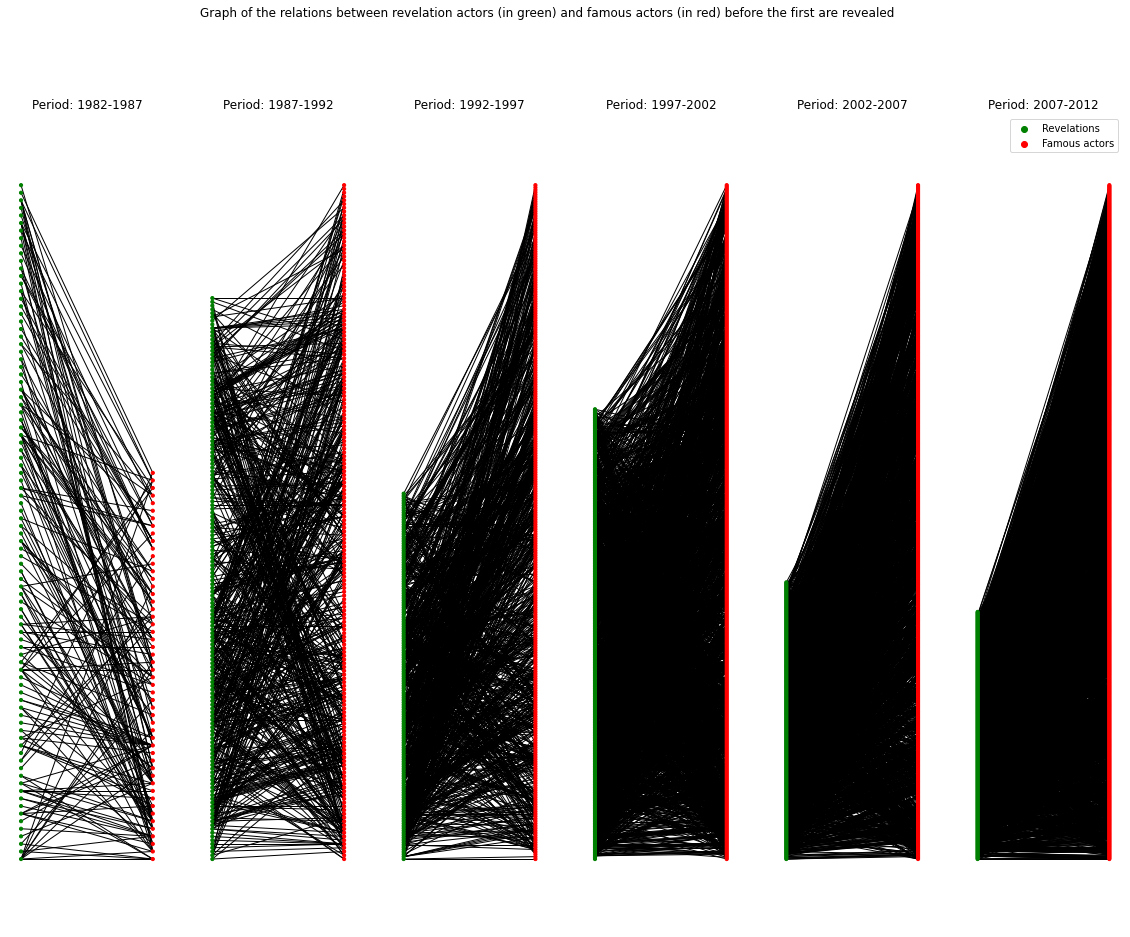

In [113]:
fig, axs = plt.subplots(1, 6, figsize=(20, 15))
for i, year in enumerate(graphs):
    G = graphs[year]['graph']
    pos = graphs[year]['pos']
    node_color = graphs[year]['node_color']
    #ix = np.unravel_index(i, axs.shape)
    #plt.sca(axs[ix])
    nx.draw(G, pos=pos, node_color=node_color, with_labels=False, node_size=10, ax=axs[i])
    axs[i].set_title("Period: {}-{}".format(year.start, year.stop))
    
fig.suptitle('Graph of the relations between revelation actors (in green) and famous actors (in red) before the first are revealed')

plt.scatter([],[], c=['green'], label='Revelations')
plt.scatter([],[], c=['red'], label='Famous actors')

plt.legend()
plt.show()

fig.tight_layout()

In [59]:
for k_year, v_year in career_booster.items():
    print("\nRESULTS FOR PERIOD: {}-{}".format(k_year.start, k_year.stop))
    print ("{:<5}: {:<18} {:<6} {:<17} {:<32} {:<5}".format('rank', 'name', 'score', 'nb_actors_boosted', 'nb_actors_boosted_at_revelation', 'nb_actors_boosted_before_revelation'))
    for k_actor, v_actor in v_year.items():
        boosted_in, ranking, actor_score_before_period, nb_actors_boosted, nb_actors_boosted_at_revelation, nb_actors_boosted_before_revelation = v_actor.values()
        print ("{:<5}: {:<18} {:<6} {:<17} {:<32} {:<5}".format(ranking, k_actor, round(actor_score_before_period), nb_actors_boosted, nb_actors_boosted_at_revelation, nb_actors_boosted_before_revelation))


RESULTS FOR PERIOD: 1982-1987
rank : name               score  nb_actors_boosted nb_actors_boosted_at_revelation  nb_actors_boosted_before_revelation
1    : Dennis Quaid       600    12                11                               1    
2    : Dan Aykroyd        442    9                 4                                5    
3    : Chevy Chase        1512   13                8                                5    
4    : William Hurt       343    8                 6                                2    
5    : Robin Williams     45     5                 2                                3    

RESULTS FOR PERIOD: 1987-1992
rank : name               score  nb_actors_boosted nb_actors_boosted_at_revelation  nb_actors_boosted_before_revelation
1    : John Candy         2203   14                12                               2    
2    : Rick Moranis       532    13                10                               3    
3    : Robert Englund     207    9                 7                